# **DCGAN using TensorFlow 2.0**

This notebook aims to learn how to use Deep Convolutional Generative Adversarial Network (DCGAN) using TensorFlow 2.0.

Thus, we will use the MNIST dataset.

## 1) Imports and preliminaries

As we will use TensorBoard to visualize the training of the DCGAN, we have to import it.

In [1]:
%load_ext tensorboard.notebook

We remove the previous logs.

In [2]:
!rm -rf ./logs/ 

Imports : 
* <font color='blue'>TensorFlow 2.0</font> ( pip install tensorflow==2.0.0-alpha0 OR pip install tensorflow-gpu==2.0.0-alpha0 )
* <font color='blue'>Datetime</font> ( pip install DateTime )
* <font color='blue'>Glob</font> ( sudo pip install glob3 )
* <font color='blue'>ImageIO</font> ( pip install imageio )
* <font color='blue'>MatPlotLib</font> ( pip install python-matplotlib )
* <font color='blue'>NumPy</font> ( pip install numpy )
* <font color='blue'>Os</font> ( already in Python's standard library )
* <font color='blue'>PIL</font> ( pip install Pillow )
* <font color='blue'>Time</font> ( already in Python's standard library )
* <font color='blue'>IPython</font> ( pip install ipython )

In [3]:
import tensorflow as tf
import datetime
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display

## 2) Loading the training and test datasets

To keep it simple, we will use the very classic MNIST dataset.

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

Reshaping and normalizing the data so the shape is compatible with our DCGAN.

In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

Defining the buffer size, and the batch size.

To learn more about the batch size and what it is about : https://www.youtube.com/watch?v=U4WB9p6ODjM

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

Transforming the tensor into a shuffled and batched dataset.

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## 3) Building the Genetator

The role of the generator is to extract the sens of the dataset, so that it can generate some images with the same sens.

To understand the generator's structure, you might want to imagine it like a **reversed Convolutional Neural Network (CNN)** :
* At the beginning of the generator, you should have what you usually find at the end of a CNN : a small image with a lot of channels (small, small, big).
* At the end of the generator, you should have what you usually find at the beginning of a CNN : an basic image (big, big, 1~3).

Our model for the generator is the following :
* input_shape of (100,) : it is the random noise every GAN needs to generate images.
* Dense 7x7x256, just like the flattened end of a CNN (small, small, big) without bias because the next layer already adds a bias.
* Batch Normalization : normalizes the output of the previous layer and helps the training. Learn more about it here : https://www.youtube.com/watch?v=dXB-KQYkzNU.
* LeakyReLU activation. Leaky ReLU instead of normal ReLU to avoid gradient problems. Learn more about it here : https://www.quora.com/What-are-the-advantages-of-using-Leaky-Rectified-Linear-Units-Leaky-ReLU-over-normal-ReLU-in-deep-learning.

* Reshape : inverse of the flatten we usually find in CNNs.

* Conv2DTranspose : inverse of the Conv2D we usually find in CNNs. No bias for the same reasons as above. (5, 5) is the size of the window, and strides is the step between each window. Then Batch Norm + Leaky ReLU.

* Conv2DTranspose + Batch Norm + Leaky ReLU

* Conv2DTranspose + TanH activation this time, because it allows the model to learn more quickly to saturate and cover the color space of the training distribution.

In [8]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

Initializing and generating the model

In [9]:
generator = generator_model()

Generation of the noise to give to the DCGAN

In [10]:
noise = tf.random.normal([1,100])

Let's see first how he processes random noise before training :

In [11]:
generated = generator(noise, training=False)

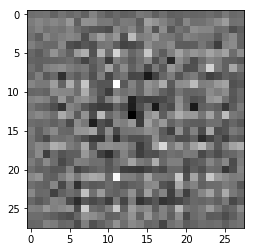

In [12]:
plt.imshow(generated[0, :, :, 0], cmap='gray')

## 4) Building the Discriminator

The role of the discriminator is to learn the difference between a real image and a generated image.

The discriminator is basically a CNN without pooling between every convolution, so that the discriminator learns how to reduce the size of each layer by itself.

We use dropout layers to build consistency and resistance, avoiding overfitting.

In [13]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

Generating the discriminator

In [14]:
discriminator = make_discriminator_model()
decision = discriminator(generated)
print (decision)

tf.Tensor([[0.00198958]], shape=(1, 1), dtype=float32)


## 5) Loss, optimizer & checkpoints determination

As the loss for the generator and the discriminator are a bit special, we define them manually.

In [15]:
loss_function = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [16]:
def discriminator_loss(real_output, fake_output):
    real_loss = loss_function(tf.ones_like(real_output), real_output)
    #La real_loss va quantifier notre loss pour distinguer les vraies images
    
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    #La fake_loss va quantifier notre loss pour distinguer les fausses images (générées)
    
    #Vrai = 1, faux =0 (array de 1 et zéros, de taille 1 dans notre cas)
    total_loss = real_loss + fake_loss
    return total_loss

In [17]:
def generator_loss(fake_output):
    #On veut que notre fausse image soit considérée vraie (1)
    return loss_function(tf.ones_like(fake_output), fake_output)


We use the classical Adam optimizer, which is basically a better gradient descent.

In [18]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

We use checkpoints so that 
* we can make a GIF afterwards
* not everything is lost in case of malfunction

In [19]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 6) Training

In [20]:
EPOCHS = 100
noise_dim = 100
num_examples_to_generate = 16 # To visualize

# We will reuse this seed over time (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

@tf.function will translate this function code (written in Eager mode) into its equivalent in Graph mode. To make it simple, Eager mode is easier to code, but takes longer to compile and run, while Graph mode is harder to code, but way faster than Eager mode. So using @tf.function, we keep the good points of each size : we code in Eager mode, and then execute it in Graph mode. More about this : https://www.youtube.com/watch?v=sI7pP7NCZFg.

Here we define what a train step does : 
* The generator builds an image, based on a random noise.
* We give the discriminator two images : a real image, and a fake image made by the generator. It will give the probability of both of them being a real image.
* We measure the generator's loss using the discriminator's prediction, and the discriminator's loss using its predictions on both images.
* We build the gradients of both losses.
* We apply the gradients.

In [21]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        
    return gen_loss, disc_loss


Here, as we train the GAN, we measure time, save the model every 15 epochs and produce images in order to make a GIF at the end.

In [22]:
def train(dataset, epochs):
    g_loss = tf.keras.metrics.Mean(name='g_loss', dtype=tf.float32)
    d_loss = tf.keras.metrics.Mean(name='d_loss', dtype=tf.float32)
    
    for epoch in range(epochs):
        start = time.time()
        
        for idx,image_batch in enumerate(dataset):
            gen_loss, disc_loss = train_step(image_batch)
            
            g_loss.update_state(gen_loss)
            tf.summary.scalar('g_loss', g_loss.result(), step=generator_optimizer.iterations)
            g_loss.reset_states()
            
            d_loss.update_state(disc_loss)
            tf.summary.scalar('d_loss', d_loss.result(), step=discriminator_optimizer.iterations)
            d_loss.reset_states()

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        
        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                               epochs,
                               seed)


Creating a function to make the GAN generate an image.

In [23]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


Configuring logs for TensorBoard

In [24]:
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
file_writer = tf.summary.create_file_writer(log_dir)


Training

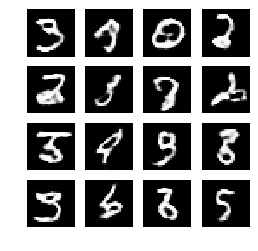

In [25]:
with file_writer.as_default():
    train(train_dataset, EPOCHS)

No need apparently

In [26]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## 7) Visualizing

In [27]:
def display_image(epoch_no):
    return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

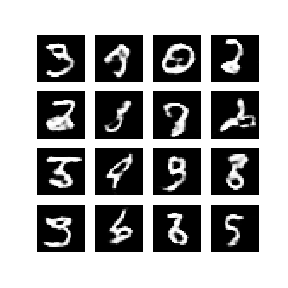

In [28]:
display_image(EPOCHS)

Creating the GIF

In [31]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./imgs/image*.png')
#     filenames = glob.glob('./image*.png')
    filenames = sorted(filenames)
    last = -1
    for i,filename in enumerate(filenames):
        frame = 10*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
    display.Image(filename=anim_file)



Exporting the TensorBoard logs

In [32]:
%tensorboard --logdir logs/fit